# Portfolio Optimization
## Imports and Font Families

In [1]:
import numpy as np
import pandas as pd
import rsome as rso
from rsome import ro
from rsome import grb_solver as grb
import matplotlib.pyplot as plt
import matplotlib

In [2]:
rc = {"mathtext.fontset": "cm",
      "text.latex.preamble": r"\usepackage{amsmath}"}
matplotlib.rc('text', usetex=True)
plt.rcParams.update(rc)
plt.rcParams['font.family'] = 'Times New Roman'

nusblue = [0/255, 66/255, 130/255]
nusorange = [239/255, 124/255, 1/255]

fs = 15   # label font size
fl = 14   # legend font size
ft = 12   # tick font size

## Portfolio Case

### Robust Optimization with Budget of Uncertainty

In [3]:
def varying_RO_gamma(Gamma):
    
    n = 150                                 # number of stocks
    i = np.arange(1, n+1)                   # indices of stocks
    p = 1.15 + i*0.05/150                   # mean returns
    delta = 0.05/450 * (2*i*n*(n+1))**0.5   # deviations of returns
                                        
    model = ro.Model()              
    x = model.dvar(n)                       # fractions of investment
    z = model.rvar(n)                       # random variables

    model.maxmin((p + delta*z) @ x,         # the max-min objective
                 rso.norm(z, np.infty) <=1, # uncertainty set constraints
                 rso.norm(z, 1) <= Gamma)   # uncertainty set constraints
    model.st(sum(x) == 1)                   # summation of x is one
    model.st(x >= 0)                        # x is non-negative

    model.solve(grb, display=False) 
    keep_values = (p@(x.get()), Gamma, delta@(x.get()), 
                   (np.square(delta))@(np.square(x.get())))
    
    return keep_values

store_values_RO = {}
for ro_gamma_values in np.linspace(0,50,500):
    store_values_RO[ro_gamma_values] = varying_RO_gamma(ro_gamma_values)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-11


In [4]:
values_ro = []
gammas_ro = []
deltax_ro = []
var_ro = []
for a,b in enumerate(store_values_RO):
    values_ro.append(store_values_RO[b][0])
    gammas_ro.append(store_values_RO[b][1])
    deltax_ro.append(store_values_RO[b][2])
    var_ro.append(store_values_RO[b][3])

### Consider Robust Satisficing with Unbounded Horizon

In [5]:
V = 1.2
n = 150                                 # number of stocks
i = np.arange(1, n+1)                   # indices of stocks
p = 1.15 + i*0.05/150                   # mean returns
delta = 0.05/450 * (2*i*n*(n+1))**0.5   # deviations of returns

In [6]:
def varying_RS_gamma(gamma):
    satisficing_model = ro.Model()

    kappa = satisficing_model.dvar()
    x = satisficing_model.dvar(n)

    satisficing_model.min(kappa)
    satisficing_model.st(p@x >= V - gamma)
    satisficing_model.st(delta*x <= kappa)
        
    satisficing_model.st(sum(x) == 1)
    
    satisficing_model.st(x >= 0)   
    satisficing_model.solve(grb, display=False)
    
    keep_values = (p@(x.get()), kappa.get(), delta@(x.get()), 
                   (np.square(delta))@(np.square(x.get())))
    
    return keep_values

store_values_RS = {}
for rs_gamma_values in np.linspace(0,0.05,200):
    store_values_RS[rs_gamma_values] = varying_RS_gamma(rs_gamma_values) 

In [7]:
values = []
kappas = []
deltax = []
varx = []
for a,b in enumerate(store_values_RS):
    values.append(store_values_RS[b][0])
    kappas.append(store_values_RS[b][1])
    deltax.append(store_values_RS[b][2])
    varx.append(store_values_RS[b][3])

### Visualization of the Efficient Frontier for Returns vs Dev

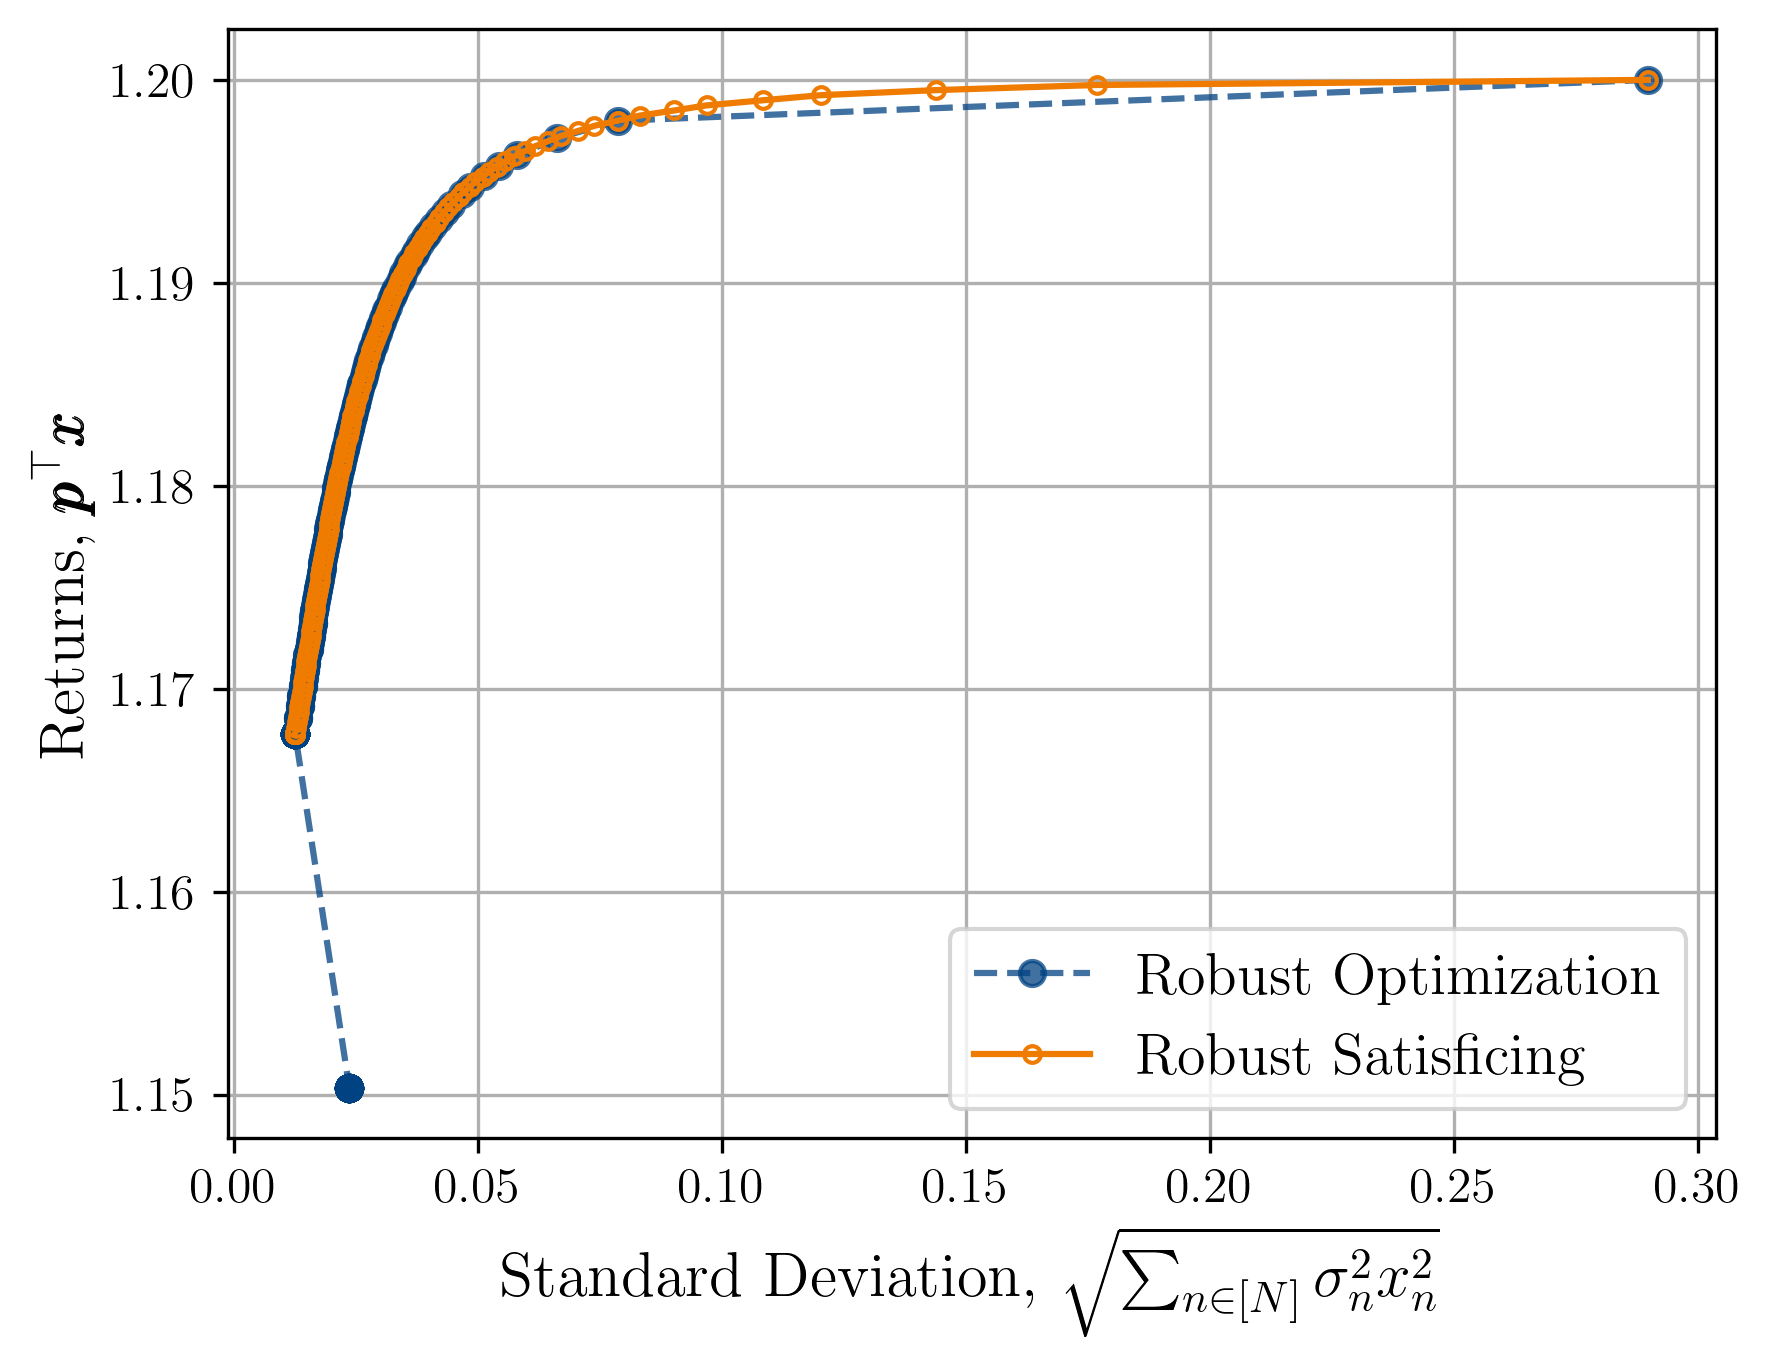

In [8]:
plt.figure(dpi=300)
plt.plot(np.sqrt(var_ro), values_ro, 
         marker='o', color=nusblue, linestyle='--', alpha=0.75,
         label='Robust Optimization')
plt.plot(np.sqrt(varx), values, 
         marker = 'o', markerfacecolor='none', markersize=4, color=nusorange,
         label='Robust Satisficing')
plt.ylabel(r'Returns, $\pmb{p}^\top \pmb{x}$', fontsize=fs)
plt.xlabel(r'Standard Deviation, $\sqrt{\sum_{n\in[N]} \sigma^2_n x^2_n}$', fontsize=fs)
plt.grid()
plt.legend(fontsize=fl)
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.show()